# Fruit Ninja
**A Kaggle Project for Regis University MSDS 686 - Deep Learning**

The purpose of this notebook is to develop a deep learning model for a dataset of our choosing from Kaggle. I chose *Fruits 360* in honor of my 3-year old who accosts me with fruits and vegetables daily, ensuring I am well trained on their nomenclature. It's only fair I share the experience digitally.

I will be using Tensorflow throughout the notebook with a basic sequential convolution model and a functional API transfer model for performative comparison. Results of training, evaluation and prediction will be displayed and plotted.

**Dataset:**<br>
Oltean, M., (2020, May). Fruits 360, Version 9.
  Retrieved June 20th, 2023 from https://www.kaggle.com/datasets/moltean/fruits.

This dataset consists of 90,380 images, sized 100x100 of 131 different classes of fruits and vegetables. Train and test sets are sized 67,692 and 22688 respectively.

Given the depth of the task, both models performed exceptionally well with 86% accuracy the basic convolution model and $$ on the transfer model. The major drawback is the long training time in basic Colab for what are both very compact models. Additionally, careful attention must be given to the dataset batch size, as a value higher than 16 tends to run basic Google Colab out of RAM. I ultimately ran this notebook on my personal hardware, which reduced the training time from 10m+ to 60s per epoch and removed the risk of running out of RAM.

## Getting the Dataset in Colab

As found [here]( https://www.kaggle.com/general/74235 ), there is commonly agreed upon format for getting a Kaggle dataset to Colab.

**IMPORTANT:** Ensure you have your `kaggle.json` file readily available to drag and drop into Colab.

In [1]:
! pip install kaggle -q
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d moltean/fruits
! unzip fruits.zip

# Imports & Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pathlib
import PIL
import tensorflow as tf

from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Brief Data Exploration

With the dataset downloaded to our Colab runtime, we can start to get familar with it. Note that there are two datasets within the file, `fruits-360-original-size` and `fruits-360_dataset`. We will be using the latter as the images have already been sized to 100 x 100 pixels.

Classes: 131
Images: 90380
Image size: 100 x 100


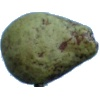

In [3]:
#dataset_path = "/content/fruits-360_dataset/fruits-360"
dataset_path = "fruits-360_dataset/fruits-360"

data_dir = pathlib.Path(dataset_path)
train_dir = pathlib.Path(data_dir, 'Training')
test_dir = pathlib.Path(data_dir, 'Test')

class_count = len(os.listdir(train_dir))
image_count = len(list(data_dir.glob('*/*/*.jpg')))

print('Classes:', class_count)
print('Images:', image_count)

img = list(data_dir.glob('*/*/*.jpg'))
img = PIL.Image.open(str(img[214]))
img_height = img.width
img_width = img.height
print('Image size:', img_height, 'x', img_width)
img.show()

IMG_SIZE = (img_height, img_width)
IMG_SHAPE = IMG_SIZE + (3,)

### Tensorflow Dataset

To neatly explore our images, we can go ahead and setup the dataset into `tf.data.Dataset` for each respective set of train, test and validation. The easiest method for this dataset is to use `tf.keras.utilze.image_dataset_from_directory` as it will create labels for each image based on the containing folder.

**NOTE:** Adjust your batch size depending upon hardware. The maximize size I was able to run on basic Google Colab was `16` before running out of memory. 

In [4]:
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

print('Train Dataset')
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Retrieve class names before AUTOTUNE
class_names = train_ds.class_names

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

print('Validation Dataset')
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print('Test Dataset')
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Train Dataset
Found 67692 files belonging to 131 classes.
Using 54154 files for training.
Validation Dataset
Found 67692 files belonging to 131 classes.
Using 13538 files for validation.
Test Dataset
Found 22688 files belonging to 131 classes.


Now in a format ready to go for our models, we can sample the images with labels.

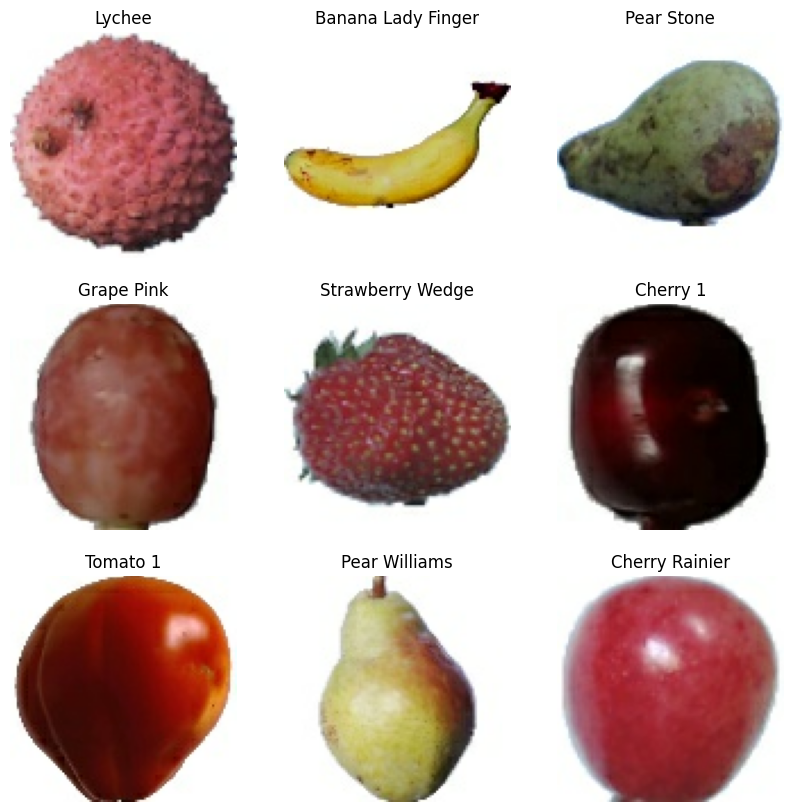

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Building the Model

We have the dataset prepared and verified, now time for the model.

First however, we'll define a function to show the results of training, evaluation and prediction performance of our models. Since this is such a class heavy dataset, we'll just use the top 10 most frequent classes in a confusion matrix to sample class accuracy.

In [6]:
def results(history, loss, accuracy, preds):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(history_dict['accuracy']) + 1)

    print('\nTraining\n')
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print('\nEvaluation\n')
    print('Loss:', loss)
    print('Accuracy:', accuracy)

    print('\nPredict\n')
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.concatenate([y for x, y in test_ds], axis=0)
    freq = [label[0] for label in Counter(true_labels).most_common()[:10]]
    freq_true_labels = [y if y in freq else "other" for y in true_labels]
    freq_pred_labels = [y if y in freq else "other" for y in pred_labels]
    cm = confusion_matrix(freq_pred_labels, freq_true_labels)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
    
    return plt.show()

### Basic Model
We'll start with a basic `Sequential` two-block `Conv2D` model with some data augmentation, `BatchNormalization`, `MaxPooling2d`, and some `Dropout`.

In [7]:
def basic_model():
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(IMG_SHAPE)),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:
num_classes = len(class_names)

model = basic_model()
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 100, 100, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 100, 100, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0

We end up with 2.5M trainable parameters, which given a dataset of this size can take a long time to run on basic Google Colab. It took an average of 12 minutes per epoch and maxes out memory utilization pretty quickly. Strongly recommend to use pro Colab or personal hardware better than basic Colab.

Epoch 1/10
847/847 [==============================] - 11s 9ms/step - loss: 1.3815 - accuracy: 0.6392 - val_loss: 0.6874 - val_accuracy: 0.7960
Epoch 2/10
847/847 [==============================] - 7s 8ms/step - loss: 0.2764 - accuracy: 0.9087 - val_loss: 0.4851 - val_accuracy: 0.8322
Epoch 3/10
847/847 [==============================] - 7s 8ms/step - loss: 0.1996 - accuracy: 0.9362 - val_loss: 0.2654 - val_accuracy: 0.9135
Epoch 4/10
847/847 [==============================] - 7s 8ms/step - loss: 0.1716 - accuracy: 0.9459 - val_loss: 0.3828 - val_accuracy: 0.8914
Epoch 5/10
847/847 [==============================] - 7s 8ms/step - loss: 0.1621 - accuracy: 0.9518 - val_loss: 0.3458 - val_accuracy: 0.8984
Epoch 6/10
355/355 [==============================] - 1s 2ms/step

Training



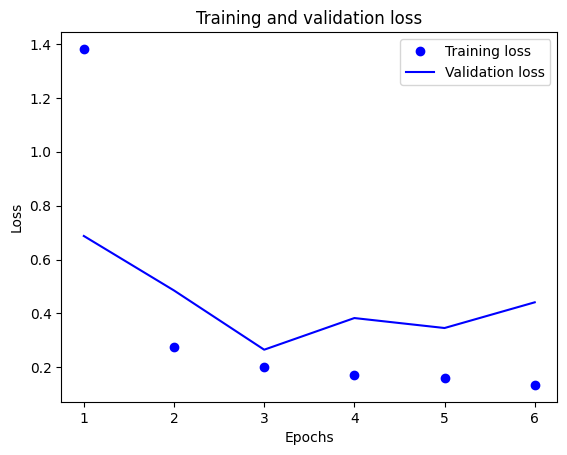

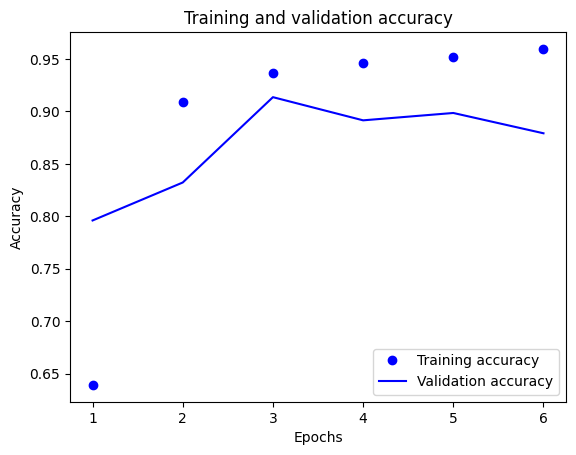


Evaluation

Loss: 0.6940304636955261
Accuracy: 0.8621297478675842

Predict



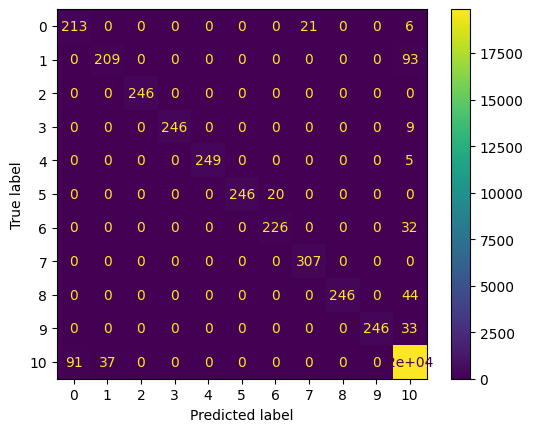

In [9]:
backend.clear_session()

history = model.fit(train_ds,
                    epochs = 10,
                    validation_data=val_ds,
                    callbacks=[EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               restore_best_weights = True)])

loss, accuracy = model.evaluate(test_ds)
preds = model.predict(test_ds)

results(history, loss, accuracy, preds)


### Results

#### Training
I had varying results with `EarlyStopping` triggering sometimes and not others, but the `val_accuracy` typically never gets above 90%. This iteration stopped on 87.91% after Epoch 6, which is quite respectable for a basic model with a deep dataset like *Fruits 360*. Running long enough, this model does tend to start overfitting and an evaluation of the test data will show us how bad.

#### Evaluation
Evaluating on the `test_ds` dataset comes up with 86.21% accuracy, very close to the validation data. I'd say `EarlyStopping` did a great job where it was as this is well within the margin of error for potential overfitting.

#### Prediction
Using a confusion matrix, we can see the top 10 most frequent classes and how well this model performs on inference. We know our accuracy from evaluation, but here we can infer where some classes are misidentified as others, but mostly see that the model performs very well while have some struggles with a few of the classes, namely #1 where almost 50% of the time it was misidentified as something other than what it is.

## Transfer Model
Transfer models utilize pretrained weights to bootstrap model performance. In this case, the `imagenet` weights for any model should greatly benefit this use case.

First, we'll define a function for setting up the transfer model via functional API this time, with data augmentation, a non-trainable base, `GlobalAveragePooling2D` to add a trainable layer, and `Dropout` to combat over-fitting.

In [11]:
def api_transfer_model(base_model):
    inputs = keras.Input(shape=IMG_SHAPE, name="img")
    x = layers.RandomFlip("horizontal_and_vertical", name="flip")(inputs)
    x = layers.RandomRotation(0.2, name='rotation')(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

I chose `MobileNetV3Small` as the transfer model as it has relatively high performance with a reasonable size for basic Colab. Now we can also fine tune our model a bit with a low, static `learning_rate` to prevent any potential stalls while training with our single layer.

In [12]:
backend.clear_session()

base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

model = api_transfer_model(base_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 100, 100, 3)]     0         
                                                                 
 flip (RandomFlip)           (None, 100, 100, 3)       0         
                                                                 
 rotation (RandomRotation)   (None, 100, 100, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 4, 4, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0     

We end up with fewer trainable parameters than our basic model, so it should be a little faster, despite being much larger and more complex with the base of `MobileNetV3Small`. It still took about 12 minutes per epoch to train.

Epoch 1/10
847/847 [==============================] - 38s 25ms/step - loss: 1.1083 - accuracy: 0.7354 - val_loss: 0.0570 - val_accuracy: 0.9832
Epoch 2/10
847/847 [==============================] - 19s 22ms/step - loss: 0.0618 - accuracy: 0.9808 - val_loss: 0.0191 - val_accuracy: 0.9939
Epoch 3/10
847/847 [==============================] - 19s 22ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0753 - val_accuracy: 0.9761
Epoch 4/10
847/847 [==============================] - 19s 22ms/step - loss: 0.0215 - accuracy: 0.9934 - val_loss: 0.0160 - val_accuracy: 0.9950
Epoch 5/10
847/847 [==============================] - 19s 22ms/step - loss: 0.0175 - accuracy: 0.9950 - val_loss: 0.0054 - val_accuracy: 0.9993
Epoch 6/10
847/847 [==============================] - 19s 22ms/step - loss: 0.0135 - accuracy: 0.9956 - val_loss: 0.0157 - val_accuracy: 0.9952
Epoch 7/10
847/847 [==============================] - 19s 22ms/step - loss: 0.0121 - accuracy: 0.9967 - val_loss: 0.0155 - val_accuracy:

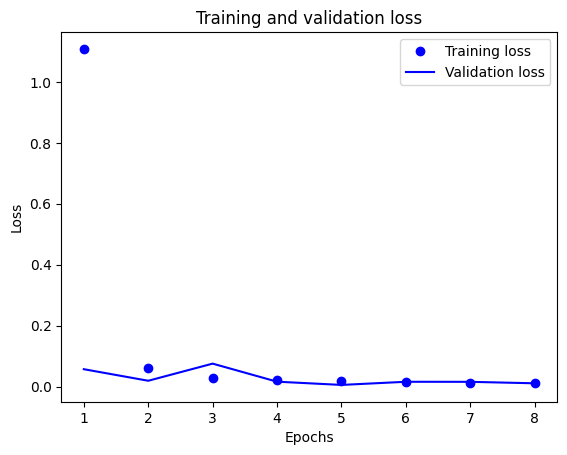

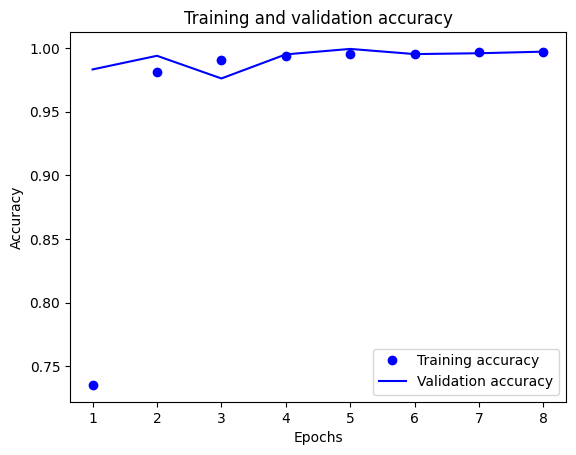


Evaluation

Loss: 0.06656007468700409
Accuracy: 0.9807828068733215

Predict



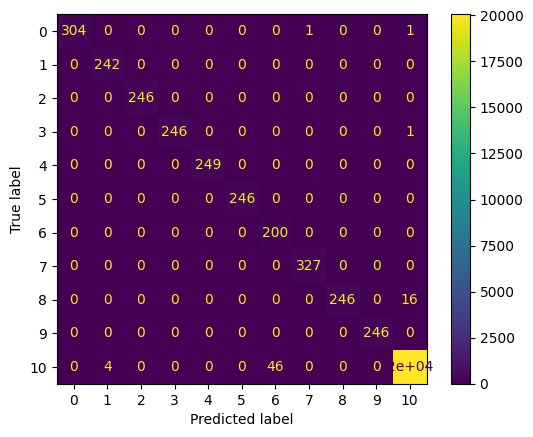

In [13]:
history = model.fit(train_ds,
                    epochs = 10,
                    validation_data=val_ds,
                    callbacks=[EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               restore_best_weights = True)])

loss, accuracy = model.evaluate(test_ds)
preds = model.predict(test_ds)

results(history, loss, accuracy, preds)

### Results

#### Training
I had varying results with `EarlyStopping` triggering sometimes and not others, but the `val_accuracy` always reaching 99%. This iteration stopped on 99.71% after Epoch 8. The pretrained weights from `imagenet` really shine on similar datasets like *Fruits 360*. Even with only one trainable layer, we don't see evidence at all of overfitting; just rock solid performance

#### Evaluation
Evaluating on the `test_ds` dataset comes up with 98.07% accuracy, very close to the validation data. Given data variance, this is to be expected and not an indicator of overfitting the model.

#### Prediction
Using a confusion matrix, we can see the top 10 most frequent classes and how well this model performs on inference. We know our accuracy from evaluation. With a 98% accuracy, there's significantly fewer occurences of misidentification, but still not zero. It seems that of our top classes, 6 and 8 had the most missed inferences.

## Conclusion
A basic convolution model of two `Conv2D` layers with `BatchNormalization`, `MaxPooling2d`, and `Dropout` achieved an accuracy of 86% while `EarlyStopping` with a `patience` of 3 based on `val_accuracy`. This model had 2.5M trainable parameters and completed training in approximately 1 minute on a 3080ti GPU. In basic Google Colab, the training takes about 12 minutes per epoch, which would have been approximately 72 minutes. Model inference shows relatively uniform performance throughout classes, with few showing more difficulty than others. Interestingly, this divergence differs from the struggling classes by the transfer model.

The transfer model utilized was an untrainable `MobileNetV3Small` base with a single `GlobalAveragePooling2D` trainable layer. This model achieved an accuracy of 98.07% on the test data with a training time of approximately 3 minutes on a 3080ti GPU. 

A very basic convolution model can be built to achieve good accuracy on the *Fruits 360*, but as expected, a transfer model utilizing pretrained weights from `imagenet` achieved near perfect accuracy with a slightly longer training period. Even if the pretrained weights from a transfer model don't come from a perfectly aligned dataset, these models still contain impressed feature recognition that can be utilized to bootstrap the training of a more purpose driven model utilizing a trainable transfer base.  